In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class ContextualThompsonSampling:
    def __init__(self, n_arms, n_features, delta=0.5,
                 R=0.01, epsilon=0.5, random_state=456):
        self.n_arms = n_arms
        self.n_features = n_features
        self.random_state = random_state
        self.n_features = n_features

        # 0 < delta < 1
        if not isinstance(delta, float):
            raise ValueError("delta should be float")
        elif (delta < 0) or (delta >= 1):
            raise ValueError("delta should be in (0, 1]")
        else:
            self.delta = delta

        # R > 0
        if not isinstance(R, float):
            raise ValueError("R should be float")
        elif R <= 0:
            raise ValueError("R should be positive")
        else:
            self.R = R

        # 0 < epsilon < 1
        if not isinstance(epsilon, float):
            raise ValueError("epsilon should be float")
        elif (epsilon < 0) or (epsilon > 1):
            raise ValueError("epsilon should be in (0, 1)")
        else:
            self.epsilon = epsilon

        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def select_arm(self, T, context):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            mu_hat = A_inv @ self.b[arm]
            v = self.R * np.sqrt(24 / self.epsilon
                             * self.n_features
                             * np.log(T / self.delta))
            mu_tilde = np.random.multivariate_normal(
            mu_hat.flat, v**2 * A_inv)[..., np.newaxis]

            scores[arm] = context @ mu_tilde
            thetas[arm] = mu_hat
        
        selected_arm = np.argmax(scores)
        return selected_arm, thetas, scores

    def update(self, arm, context, reward):
        self.A[arm] += np.outer(context, context)
        self.b[arm] += reward * context

In [3]:
# Create class object for a single linear ucb disjoint arm
class cbts_arm():
    
    def __init__(self, arm_index, d, R = 0.01, epsilon = 0.5, delta = 0.5):
        
        # Track arm index
        self.arm_index = arm_index
        
        self.R = R
        self.epsilon = epsilon
        self.delta = delta
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_bts(self, x_array, T):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        mu_hat = A_inv @ self.b

        v = self.R * np.sqrt(24 / self.epsilon
                    * self.A.shape[0]
                    * np.log(T / self.delta))
        mu_tilde = np.random.multivariate_normal(
        mu_hat.flat, v**2 * A_inv)[..., np.newaxis]

        return x_array @ mu_tilde


    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x 

In [4]:
class cbts_policy():
    
    def __init__(self, K_arms, d, R):
        self.K_arms = K_arms
        self.cbts_arms = [cbts_arm(arm_index = i, d = d, R = R) for i in range(K_arms)]
        
    def select_arm(self, x_array, T):
        # Initiate ucb to be 0
        highest_bts = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_bts = self.cbts_arms[arm_index].calc_bts(x_array, T)
            
            # If current arm is highest than current highest_ucb
            if arm_bts > highest_ucb:
                
                # Set new max ucb
                highest_ucb = highest_bts
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_bts == highest_bts:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm

    def select_k_arms(self, x_array, T, k):
        arm_ucbs = sorted(((arm_index, self.cbts_arms[arm_index].calc_bts(x_array, T)) for arm_index in range(self.K_arms)), key=lambda x: x[1], reverse=True)
        return [x for x, y in arm_ucbs[:k]]

In [5]:
def ctr_simulator(K_arms, d, R, data_path):
    # Initiate policy
    cbts_policy_object = cbts_policy(K_arms = K_arms, d = d, R = R)
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:
        flag = True
        for line_data in tqdm(f):
            if flag:
                flag = False
                continue
            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split(',')[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split(',')[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split(',')[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            # arm_index = linucb_policy_object.select_arm(data_x_array)
            # Select top 3 arms
            arm_indexes = cbts_policy_object.select_k_arms(data_x_array, aligned_time_steps + 1, k=3)

            # If data_reward == 1 (user picked that arm)
            # Check if data_arm in arm_indexes
            # No = 0, yes = 1
            if data_reward == 1:
                arm_index = data_arm
                reward = int(data_arm in arm_indexes)
                # Use reward information for the chosen arm to update
                cbts_policy_object.cbts_arms[arm_index].reward_update(reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, cbts_policy_object)

10001it [19:23,  8.60it/s]


Text(0.5, 1.0, 'R = 0.05')

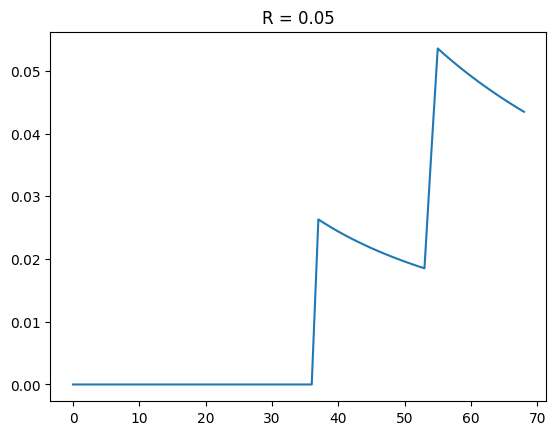

In [38]:
R = 0.05
data_path = "test_bts_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 61, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

0it [00:00, ?it/s]

10001it [55:11,  3.02it/s]


Text(0.5, 1.0, 'R = 0.05')

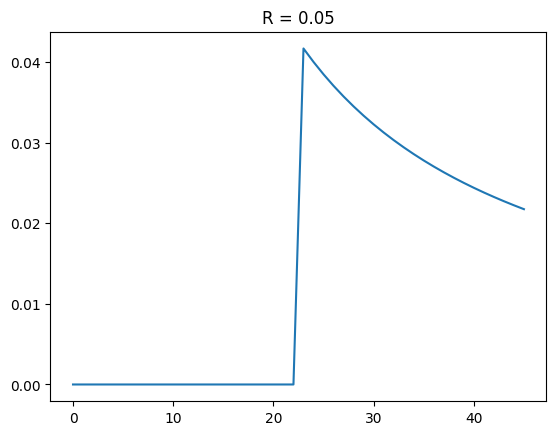

In [6]:
R = 0.05
data_path = "test_bts_women.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 46, d = 70, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [1:35:08,  1.75it/s]


Text(0.5, 1.0, 'R = 0.05')

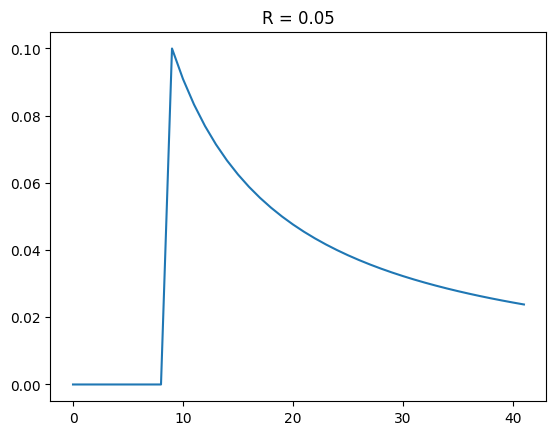

In [7]:
R = 0.05
data_path = "test_bts_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 107, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

0it [00:00, ?it/s]

10001it [14:52, 11.21it/s]


Text(0.5, 1.0, 'R = 0.01')

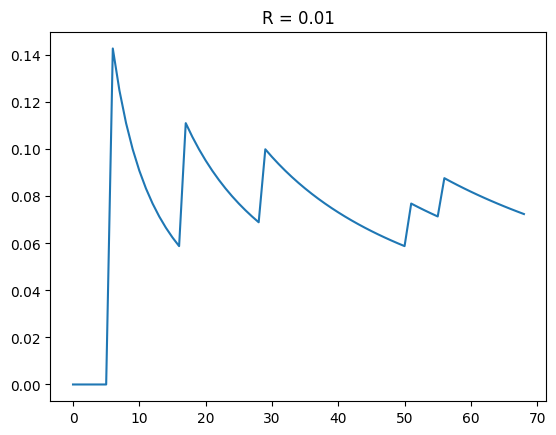

In [8]:
R = 0.01
data_path = "test_bts_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 61, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [22:06,  7.54it/s]


Text(0.5, 1.0, 'R = 0.01')

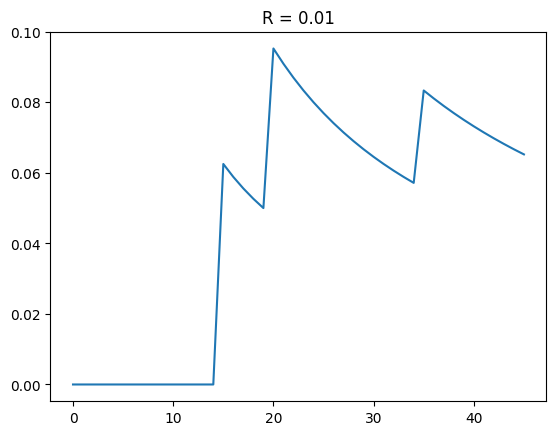

In [9]:
R = 0.01
data_path = "test_bts_women.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 46, d = 70, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [1:27:21,  1.91it/s]


Text(0.5, 1.0, 'R = 0.01')

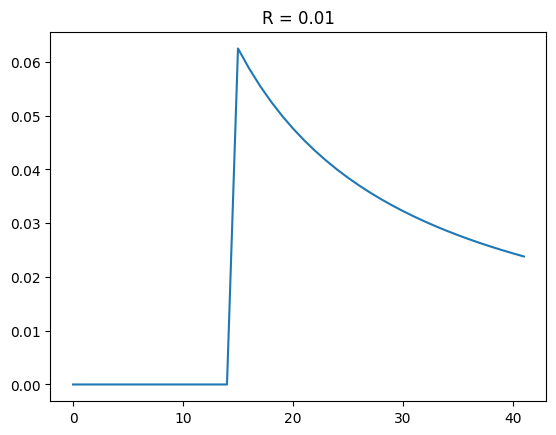

In [10]:
R = 0.01
data_path = "test_bts_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 107, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [15:35, 10.68it/s]


Text(0.5, 1.0, 'R = 0.01')

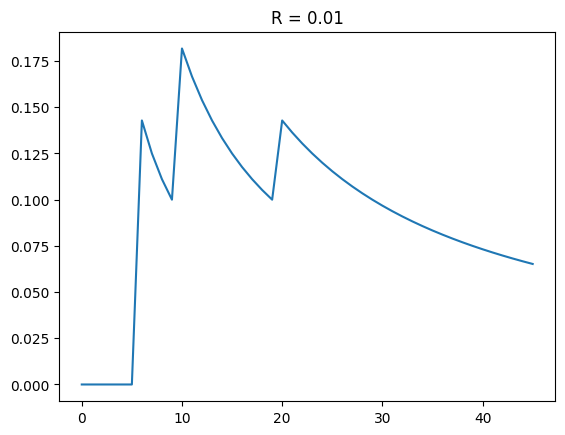

In [6]:
R = 0.01
data_path = "test_random_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 60, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [22:56,  7.27it/s]


Text(0.5, 1.0, 'R = 0.01')

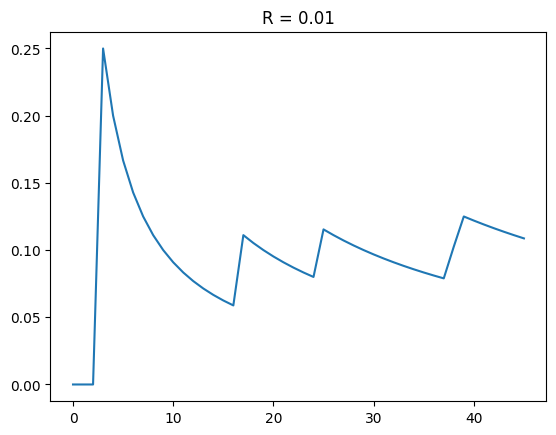

In [7]:
R = 0.01
data_path = "test_random_women.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 46, d = 70, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [1:15:21,  2.21it/s]


Text(0.5, 1.0, 'R = 0.01')

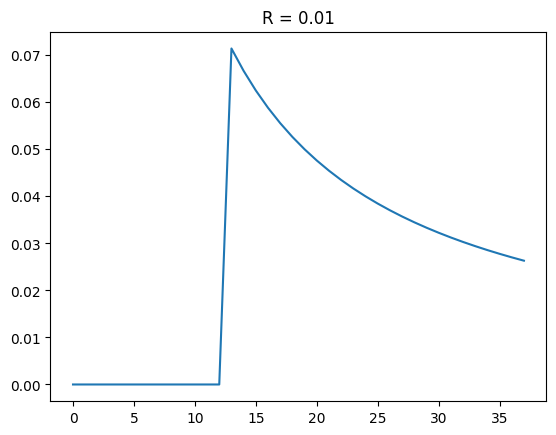

In [8]:
R = 0.01
data_path = "test_random_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 105, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [36:35,  4.56it/s]


Text(0.5, 1.0, 'R = 0.05')

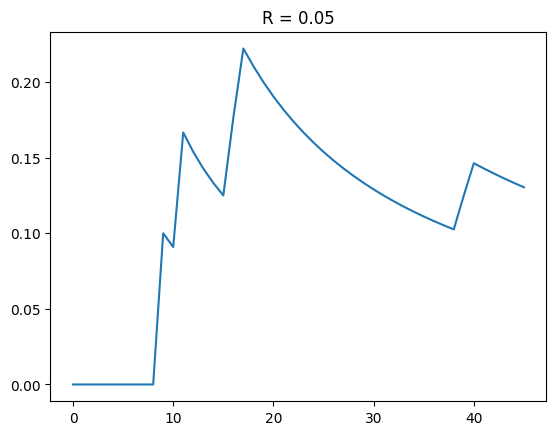

In [ ]:
R = 0.05
data_path = "test_random_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 60, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

In [14]:
import pandas as pd
df = pd.read_csv('linucb.csv')

Text(0.5, 1.0, 'Comparison of CTS with R = 0.05 and LinUCB with Alpha = 1 on Random Men Dataset')

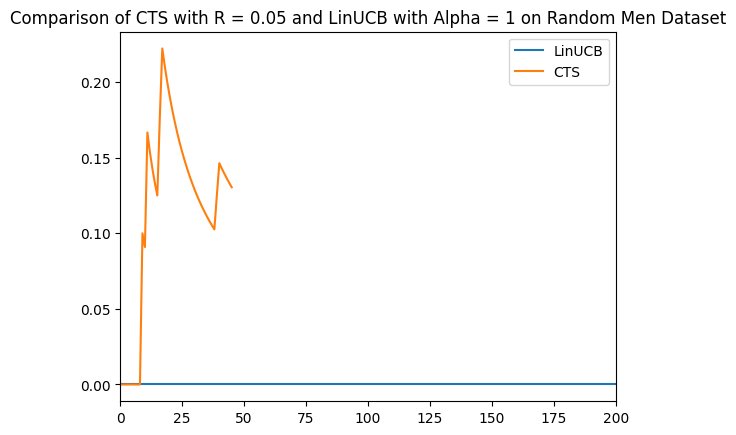

In [25]:
fig, ax = plt.subplots()
line1 = ax.plot(df["0"], label = 'LinUCB')
line2 = ax.plot(aligned_ctr, label = 'CTS')
ax.set_xlim(left = 0, right = 200)
ax.legend()
ax.set_title("Comparison of CTS with R = 0.05 and LinUCB with Alpha = 1 on Random Men Dataset")

10001it [22:40,  7.35it/s]


Text(0.5, 1.0, 'R = 0.05')

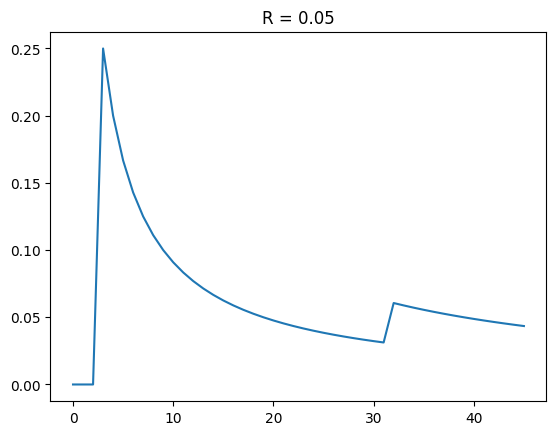

In [10]:
R = 0.05
data_path = "test_random_women.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 46, d = 70, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))

10001it [1:13:35,  2.26it/s]


Text(0.5, 1.0, 'R = 0.05')

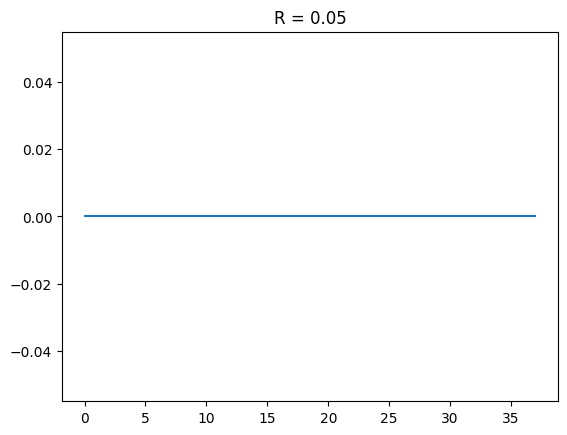

In [11]:
R = 0.05
data_path = "test_random_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 105, R = R, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("R = "+str(R))